In [165]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import matplotlib.dates as mdates

%matplotlib inline

In [166]:
flight = 1

In [167]:
basedir = 'data/P3_2017/LGS'
infile = 'OIB_P3_F200' + str(flight) + '_exportfromGeosoft.csv'
# infile = 'OIB_P3_F2001_exportfromGeosoft.csv'
# infile = 'OIB_P3_F2004_exportfromGeosoft.csv'
df = pd.read_csv(os.path.join(basedir, infile))
df.head()

,Line,AccBiasX,AccBiasY,AccBiasZ,AccBiasZ_mgal,Corrected_Free_Air_DgS,diff_att_noatt,diff_oib_grav4,diff_oib_grav4_70,diff_oib_grav4_70_clip,...,Pitch,Roll,seconds,static_en,static_st,unixtime,UTCDate,x,y,zbias_corr
0,D2001,0.000633,-0.001196,-0.000103,-10.2868,108.571,1.007921,14.151178,14.084874,14.084874,...,-1.095306,0.097764,40597,-18.3,-23.9,1490181397,2017/03/22,-587786.161012,-1.342347e+06,18.613200
1,D2001,0.000637,-0.001183,-0.000108,-10.7741,110.105,1.231149,14.404454,13.962782,13.962782,...,-1.286674,0.097449,40598,-18.3,-23.9,1490181398,2017/03/22,-587790.379637,-1.342345e+06,18.125717
2,D2001,0.000641,-0.001176,-0.000113,-11.2547,110.393,1.342680,14.756877,13.857421,13.857421,...,-1.356420,0.086471,40599,-18.3,-23.9,1490181399,2017/03/22,-587797.003847,-1.342343e+06,17.644933
3,D2001,0.000646,-0.001169,-0.000115,-11.5110,109.255,1.463912,14.869320,13.768654,13.768654,...,-1.356472,0.033724,40600,-18.3,-23.9,1490181400,2017/03/22,-587806.107320,-1.342340e+06,17.388450
4,D2001,0.000652,-0.001164,-0.000119,-11.9362,106.520,1.438000,15.291789,13.696342,13.696342,...,-1.263704,0.001444,40601,-18.3,-23.9,1490181401,2017/03/22,-587817.675328,-1.342336e+06,16.963067


In [168]:
df.keys()

Index(['Line', 'AccBiasX', 'AccBiasY', 'AccBiasZ', 'AccBiasZ_mgal',
       'Corrected_Free_Air_DgS', 'diff_att_noatt', 'diff_oib_grav4',
       'diff_oib_grav4_70', 'diff_oib_grav4_70_clip', 'diff_oib_grav4_70_corr',
       'diff_oib_grav4_clip', 'diff_oib_zbias', 'diff_oib_zbias_clip', 'drift',
       'drift_correction', 'duration', 'Ellipsoidal_height', 'Free_Air_DgS',
       'grav', 'grav4', 'grav4_70', 'grav4_70_st', 'grav_4_70_corr',
       'grav_4_corr', 'H_Ell', 'Heading', 'hms', 'imu_temp_C', 'increment',
       'Latitude', 'Longitude', 'NS', 'oib_10_11_12', 'PDOP', 'Pitch', 'Roll',
       'seconds', 'static_en', 'static_st', 'unixtime', 'UTCDate', 'x', 'y',
       'zbias_corr'],
      dtype='object')

In [169]:
df['datestring'] = pd.to_datetime(df['unixtime'],unit='s')
df = df.set_index(pd.to_datetime(df['unixtime'],unit='s'))

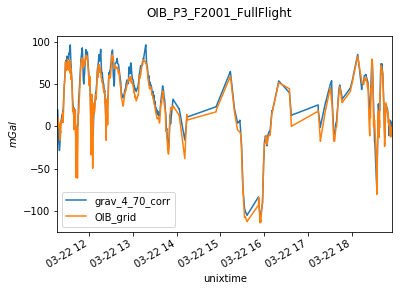

In [170]:
fig, ax = plt.subplots()
ln1 = df['grav_4_70_corr'].plot()
ln2 = df['oib_10_11_12'].plot(label='OIB_grid')
ax.set_ylabel('$mGal$')
plt.legend()
plt.suptitle(infile[:12] + '_FullFlight')
plt.savefig('figs/' + infile[:12] + '_Grav_iMAR-vs-OIB__FullFlight.png')

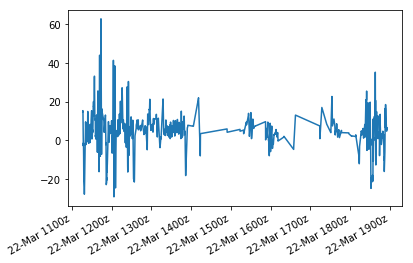

In [171]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(df['grav_4_70_corr'] - df['oib_10_11_12'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H%Mz'))
fig.autofmt_xdate()

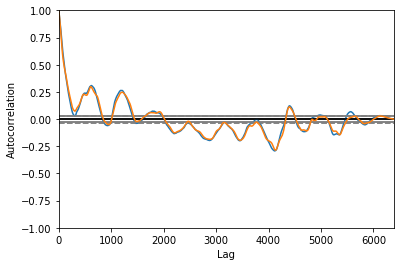

In [172]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['grav4'])
# autocorrelation_plot(df['grav_4_70_corr'])
autocorrelation_plot(df['oib_10_11_12'])
# plt.legend()
plt.show()

Text(0,0.5,'$^{\\circ}C$')

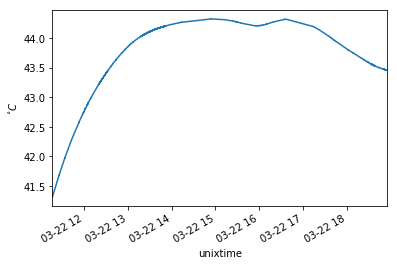

In [173]:
fig, ax = plt.subplots()
df['imu_temp_C'].plot()
ax.set_ylabel('$^{\circ}C$')

In [174]:
# F001
begin_line = datetime(2017, 3, 22, 13, 18)
end_line = datetime(2017, 3, 22, 13, 52)
# # F004
# begin_line = datetime(2017, 3, 27, 15, 35)
# end_line = datetime(2017, 3, 27, 16, 50)

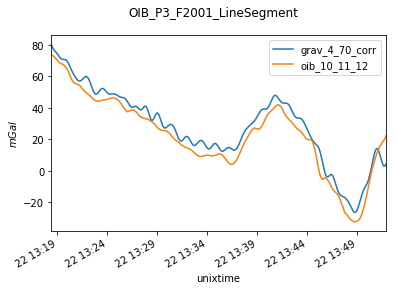

In [175]:
fig, ax = plt.subplots()
# gravity = gravity[(begin_line <= gravity.index) & (gravity.index <= end_line)]
df[['grav_4_70_corr', 'oib_10_11_12']].loc[begin_line: end_line].plot(ax=ax)
ax.set_ylabel('$mGal$')
plt.suptitle(infile[:12] + '_LineSegment')
plt.savefig('figs/' + infile[:12] + '_Grav_iMAR-vs-OIB_LineSegment.png')

In [176]:
df['imar_bias'] = df['grav_4_70_corr'] - df['oib_10_11_12']

Text(0,0.5,'$mGal$')

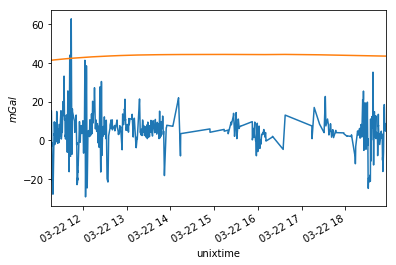

In [177]:
fig, ax = plt.subplots()
# df['imar_bias'].loc[begin_line: end_line].plot()
df['imar_bias'].plot()
df['imu_temp_C'].plot()
ax.set_ylabel('$mGal$')



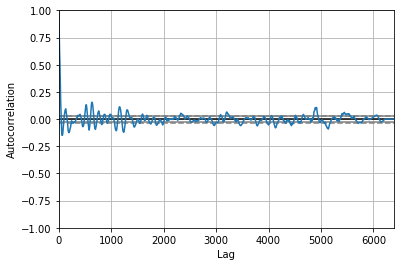

In [96]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['imar_bias'])
plt.show()

## LOWESS
Need to adjust "frac" in the lowess module to get a compatible, linear relationship.

In [180]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
x = df['seconds']
y = df['imar_bias']

# lowess will return our "smoothed" data with a y value for at every x-value
my_frac = 0.5
lowess = sm.nonparametric.lowess(y, x, frac=my_frac)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(4000000)]

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)
df['imar_bias_lowess'] = lowess_y

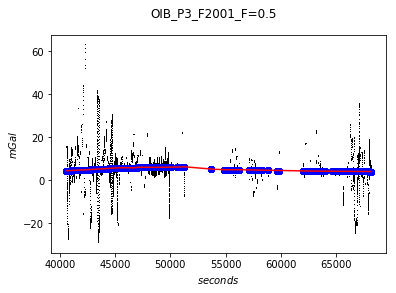

In [181]:
fig, ax = plt.subplots()
plt.plot(x, y, 'k,')
plt.plot(lowess_x, lowess_y, 'bo')
plt.plot(xnew, ynew, 'r-')
ax.set_xlabel('$seconds$')
ax.set_ylabel('$mGal$')
# ax.text(1,1, infile[:12] + '_' + str(my_frac))
plt.suptitle(infile[:12] + '_F=' + str(my_frac))
plt.savefig('figs/' + infile[:12] + '_iMARbias-lowess_F=' + str(my_frac) + '.png')

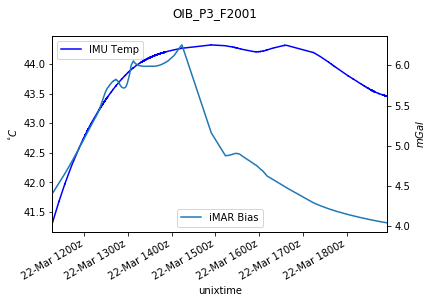

In [99]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# # For a third trace
# ax2, ax3 = ax.twinx(), ax.twinx()
# rspine = ax3.spines['right']
# rspine.set_position(('axes', 1.25))
# ax3.set_frame_on(True)
# ax3.patch.set_visible(False)
# fig.subplots_adjust(right=0.75)

ax = df['imu_temp_C'].plot(ax=ax, style='b-', label='IMU Temp')
ax.set_ylabel('$^{\circ}C$')
ax.legend(loc="upper left")
ax2 = df['imar_bias_lowess'].plot(ax=ax2, secondary_y=True, label='iMAR Bias')
ax2.set_ylabel('$mGal$')
ax2.set_xlabel('Time (UTC)')
ax2.legend(loc="lower center")
# df['imar_bias'].plot(ax=ax3, style='g-', alpha=0.2)
# plt.legend([ax, ax2],["Temperature", "iMAR bias"])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H%Mz'))
fig.autofmt_xdate()
plt.suptitle(infile[:12])
plt.savefig('figs/' + infile[:12] + '_iMARbias-vs-IMUtemp.png')

### Shift the IMU temps
First find the offset in peaks (better to do this objectively using CC)

In [100]:
lag_argmax = df['imar_bias_lowess'].argmax() - df['imu_temp_C'].argmax()
print(lag_argmax)

-1 days +23:19:52


Test shifting by max offset

Text(0,0.5,'$^{\\circ}C$')

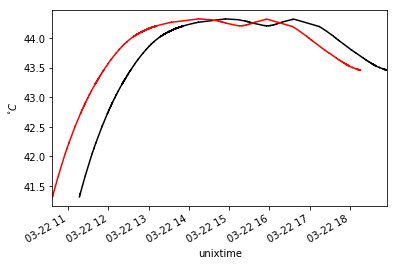

In [101]:
# df['imu_temp_C'].shift(2000).plot(color='blue')
fig, ax = plt.subplots()
df['imu_temp_C'].shift(0).plot(color='black')
df['imu_temp_C'].shift(periods=1, freq=lag_argmax).plot(color='red')
ax.set_ylabel('$^{\circ}C$')


Text(0,0.5,'$mGal$')

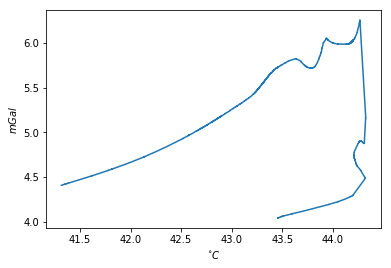

In [102]:
# df['imu_temp_C_shift'] = df['imu_temp_C'].shift(periods=1, freq=lag_argmax)
df['imu_temp_C_shift'] = df['imu_temp_C']

# plt.plot(df['imu_temp_C'].shift(periods=1, freq=lag_argmax), df['imar_bias'])
fig, ax = plt.subplots()
plt.plot(df['imu_temp_C_shift'], df['imar_bias_lowess'])
ax.set_xlabel('$^{\circ}C$')
ax.set_ylabel('$mGal$')

Text(0,0.5,'$mGal$')

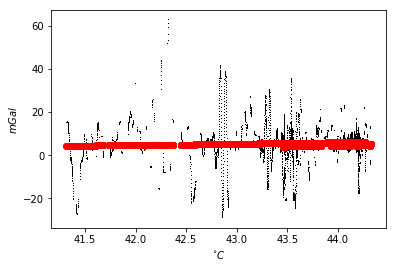

In [103]:
fig, ax = plt.subplots()
plt.plot(df['imu_temp_C'], df['imar_bias'], 'k,')
plt.plot(df['imu_temp_C'], df['imar_bias_lowess'],'ro')
ax.set_xlabel('$^{\circ}C$')
ax.set_ylabel('$mGal$')

Pandas correlation

In [104]:
# df[['imu_temp_C', 'imar_bias']].corr()
print(df.corr()['imar_bias_lowess'].tail())

y                   0.507818
zbias_corr          0.222927
imar_bias           0.138719
imar_bias_lowess    1.000000
imu_temp_C_shift    0.466501
Name: imar_bias_lowess, dtype: float64


## Linear Regression

In [105]:
import statsmodels.api as sm
# result = sm.ols(formula="A ~ B + C", data=df).fit()
# result = sm.ols(formula="imar_bias ~ imu_temp_C", data=df).fit()
ols = sm.OLS(df.imar_bias_lowess, df.imu_temp_C_shift).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:       imar_bias_lowess   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 3.587e+05
Date:                Wed, 23 May 2018   Prob (F-statistic):               0.00
Time:                        17:02:53   Log-Likelihood:                -6776.5
No. Observations:                6386   AIC:                         1.356e+04
Df Residuals:                    6385   BIC:                         1.356e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
imu_temp_C_shift     0.1205      0.000  

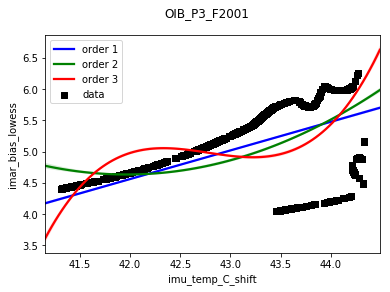

In [106]:
import seaborn as sns
# Generate a scatter plot of 'weight' and 'mpg' using red circles
plt.scatter(df['imu_temp_C_shift'], df['imar_bias_lowess'], label='data', color='black', marker=',')

# Plot in blue a linear regression of order 1 between 'weight' and 'mpg'
sns.regplot(x='imu_temp_C_shift', y='imar_bias_lowess', data=df, 
            order=1, 
            color='blue', scatter=None, label='order 1')

# Plot in green a linear regression of order 2 between 'weight' and 'mpg'
sns.regplot(x='imu_temp_C_shift', y='imar_bias_lowess', data=df, 
            order=2, 
            color='green', scatter=None, label='order 2')

# Plot in green a linear regression of order 2 between 'weight' and 'mpg'
sns.regplot(x='imu_temp_C_shift', y='imar_bias_lowess', data=df, 
            order=3, 
            color='red', scatter=None, label='order 3')
plt.legend()
plt.suptitle(infile[:12])
plt.savefig('figs/' + infile[:12] + '_test_regression_order3.png')

# ALL P3 data

In [108]:
basedir = 'data/P3_2017/LGS'
infile = 'OIB_P3_exportfromGeosoft.csv'
df = pd.read_csv(os.path.join(basedir, infile))
df['datestring'] = pd.to_datetime(df['unixtime'],unit='s')
df = df.set_index(pd.to_datetime(df['unixtime'],unit='s'))
df.head()

,Line,AccBiasX,AccBiasY,AccBiasZ,AccBiasZ_mgal,Corrected_Free_Air_DgS,diff_att_noatt,diff_oib_grav4,diff_oib_grav4_70,diff_oib_grav4_70_clip,...,Roll,seconds,static_en,static_st,unixtime,UTCDate,x,y,zbias_corr,datestring
unixtime,,,,,,,,,,,,,,,,,,,,,
2017-03-22 11:16:37,D2001,0.000633,-0.001196,-0.000103,-10.2868,108.571,1.007921,14.151178,14.084874,14.084874,...,0.097764,40597,-18.3,-23.9,1490181397,2017/03/22,-587786.161012,-1.342347e+06,18.613200,2017-03-22 11:16:37
2017-03-22 11:16:38,D2001,0.000637,-0.001183,-0.000108,-10.7741,110.105,1.231149,14.404454,13.962782,13.962782,...,0.097449,40598,-18.3,-23.9,1490181398,2017/03/22,-587790.379637,-1.342345e+06,18.125717,2017-03-22 11:16:38
2017-03-22 11:16:39,D2001,0.000641,-0.001176,-0.000113,-11.2547,110.393,1.342680,14.756877,13.857421,13.857421,...,0.086471,40599,-18.3,-23.9,1490181399,2017/03/22,-587797.003847,-1.342343e+06,17.644933,2017-03-22 11:16:39
2017-03-22 11:16:40,D2001,0.000646,-0.001169,-0.000115,-11.5110,109.255,1.463912,14.869320,13.768654,13.768654,...,0.033724,40600,-18.3,-23.9,1490181400,2017/03/22,-587806.107320,-1.342340e+06,17.388450,2017-03-22 11:16:40
2017-03-22 11:16:41,D2001,0.000652,-0.001164,-0.000119,-11.9362,106.520,1.438000,15.291789,13.696342,13.696342,...,0.001444,40601,-18.3,-23.9,1490181401,2017/03/22,-587817.675328,-1.342336e+06,16.963067,2017-03-22 11:16:41


In [145]:
# introduce some floats in our x-values
# df['imar_bias'] = df['grav_4_70_corr'] - df['oib_10_11_12']

df['imar_bias'] = df['grav_4_corr'] - df['oib_10_11_12']

In [164]:
x = df['seconds']
y = df['imar_bias']

# lowess will return our "smoothed" data with a y value for at every x-value
my_frac = 0.5
lowess = sm.nonparametric.lowess(y, x, frac=my_frac)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(40000000)]

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)
df['imar_bias_lowess'] = lowess_y

ValueError: Length of values does not match length of index

Text(0,0.5,'$mGal$')

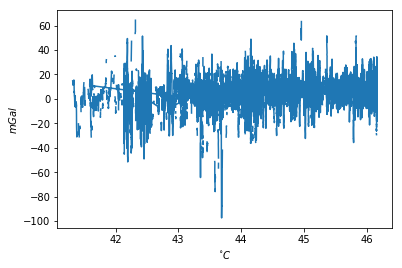

In [147]:
# plt.plot(df['imu_temp_C'].shift(periods=1, freq=lag_argmax), df['imar_bias'])
fig, ax = plt.subplots()
plt.plot(df['imu_temp_C'], df['imar_bias'])
ax.set_xlabel('$^{\circ}C$')
ax.set_ylabel('$mGal$')

In [163]:
# df[['imu_temp_C', 'imar_bias']].corr()
print(df.corr()['imar_bias'].tail())

x                   0.190152
y                  -0.132256
zbias_corr          0.048575
imar_bias           1.000000
imu_temp_C_shift    0.230304
Name: imar_bias, dtype: float64


In [149]:
from statsmodels.formula.api import ols
res=ols('imar_bias ~ imu_temp_C', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              imar_bias   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     3220.
Date:                Wed, 23 May 2018   Prob (F-statistic):               0.00
Time:                        22:17:23   Log-Likelihood:            -2.1300e+05
No. Observations:               57483   AIC:                         4.260e+05
Df Residuals:                   57481   BIC:                         4.260e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -89.2333      1.651    -54.061      0.0

In [151]:
import statsmodels.formula.api as smf

# 2nd order polynomial
poly_2 = smf.ols('imar_bias ~ 1 + imu_temp_C + I(imu_temp_C ** 2.0)', data=df).fit()
print(poly_2.summary())

                            OLS Regression Results                            
Dep. Variable:              imar_bias   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1696.
Date:                Wed, 23 May 2018   Prob (F-statistic):               0.00
Time:                        22:34:40   Log-Likelihood:            -2.1292e+05
No. Observations:               57483   AIC:                         4.259e+05
Df Residuals:                   57480   BIC:                         4.259e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -788.8730 

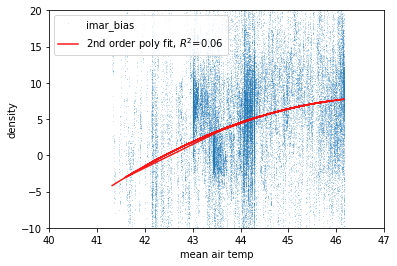

In [161]:
plt.plot(df.imu_temp_C, df.imar_bias, ',', alpha=0.2)
plt.plot(df.imu_temp_C, poly_2.predict(df), 'r-', 
         label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)
plt.xlim((40, 47))
plt.ylim((-10, 20))
plt.xlabel('mean air temp')
plt.ylabel('density')
plt.legend(loc="upper left")

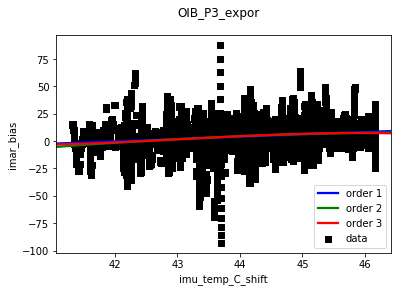

In [115]:
import seaborn as sns
plt.scatter(df['imu_temp_C'], df['imar_bias'], label='data', color='black', marker=',')
sns.regplot(x='imu_temp_C', y='imar_bias', data=df, 
            order=1, 
            color='blue', scatter=None, label='order 1')
sns.regplot(x='imu_temp_C', y='imar_bias', data=df, 
            order=2, 
            color='green', scatter=None, label='order 2')
sns.regplot(x='imu_temp_C', y='imar_bias', data=df, 
            order=3, 
            color='red', scatter=None, label='order 3')
plt.legend()
plt.suptitle(infile[:12])
plt.savefig('figs/' + infile[:12] + '_test_regression_order3.png')

# APPENDIX
1) ARIMA

2) Read in IMU temps directly

3) Testing a Lead-lag cross-correlation

### ARIMA
DEAD END (for now)

In [ ]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 70) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


In [ ]:
# import warnings

# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df['imar_bias'],
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [ ]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(df['imar_bias'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 70),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## read RAW IMU temps

In [ ]:
basedir = 'data/P3_2017/LGS/imu_temps/'
# infile = 'OIB-P3_20170327_F2004_IMUTEMPS_095751.csv'
infile = 'OIB-P3_20170322_F2001_IMUTEMPS_104019.csv'

df_temp = pd.read_csv(os.path.join(basedir, infile))
df_temp.head()

In [ ]:
df_temp = df_temp.set_index(pd.to_datetime(df_temp['unix_utc'],unit='s'))
df_temp.head()

In [ ]:
df_temp['imu_temp_C'].plot()

## Lead-lag correlation function

In [ ]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print '\n#<lagcorr>: Computing lagged-correlations at lags:',lag

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result
